# Overturning Circulation

In [2]:
import xgcm
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import hvplot.xarray

plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
from dask_gateway import Gateway
gway = Gateway()
cluster = gway.new_cluster()
cluster

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [4]:
cluster.scale(10)

In [16]:
from intake import open_catalog
from xmitgcm.llcreader import faces_dataset_to_latlon

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["ECCOv4r3"].to_dask()

In [17]:
import pooch
POOCH = pooch.create(
    path=pooch.os_cache("ecco-basin-masks"),
    # Use the figshare DOI
    base_url="doi:10.6084/m9.figshare.9932162.v1/",
    registry={
        'basins.meta': None,
        'basins.data': None
    },
)

POOCH.fetch('basins.meta')
POOCH.fetch('basins.data')


'/home/jovyan/.cache/ecco-basin-masks/basins.data'

In [18]:
import xmitgcm

llc90 = {'has_faces': True, 'ny': 13*90, 'nx': 90,
    'ny_facets': [3*90, 3*90, 90, 3*90, 3*90],
    'face_facets': [0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 4, 4, 4],
    'facet_orders': ['C', 'C', 'C', 'F', 'F'],
    'face_offsets': [0, 1, 2, 0, 1, 2, 0, 0, 1, 2, 0, 1, 2],
    'transpose_face' : [False, False, False,
    False, False, False, False,
    True, True, True, True, True, True]}

basin_data = xmitgcm.utils.read_mds(
    '/home/jovyan/.cache/ecco-basin-masks/basins',
    iternum=None,
    extra_metadata=llc90,
    chunks='2D'
)

ds['basins'] = ds.Depth.dims, basin_data['basins']
ds

<xarray.Dataset>
Dimensions:    (time: 288, k_l: 50, face: 13, j: 90, i: 90, k: 50, i_g: 90, j_g: 90, time_snp: 287, k_p1: 51, k_u: 50)
Coordinates: (12/37)
    Depth      (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    PHrefC     (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    PHrefF     (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    ...         ...
    rA         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAs        (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAw        (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAz        (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
Data variables: (12/36)
    ADVr_SLT   (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVr_TH    (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVx_SLT   (time, k, face, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVx_TH    (time, k, face, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVy_SLT   (time, k, face, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVy_TH    (time, k, face, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ...         ...
    oceFWflx   (time, face, j, i) float32 dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    oceQsw     (time, face, j, i) float32 dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    oceSPtnd   (time, k, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    oceTAUX    (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    oceTAUY    (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    basins     (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>

In [19]:
# convert to lat-lon grid
ds = faces_dataset_to_latlon(ds)
# trim y dimension
ds = ds.isel(j=slice(30,None), j_g=slice(30, None))

new_coords = {
    'lon_c': ds.XC[100].reset_coords(drop=True),
    'lon_g': ds.XG[100].reset_coords(drop=True),
    'lat_c': ds.YC[:, 0].reset_coords(drop=True),
    'lat_g': ds.YG[:, 0].reset_coords(drop=True)
}
ds = ds.assign_coords(new_coords)
for c in new_coords:
    ds[c].load()
    
# fix non-monotonic lat lon
ds.lon_c.data[ds.lon_c.data < ds.lon_c.data[0]] += 360
ds.lon_g.data[ds.lon_g.data < ds.lon_g.data[0]] += 360

swap_dims = {
    'i': 'lon_c', 'j': 'lat_c', 'i_g': 'lon_g', 'j_g': 'lat_g',
    'k': 'Z', 'k_l': 'Zl', 'k_u': 'Zu', 'k_p1': 'Zp1'
}

ds = ds.swap_dims(swap_dims)

attrs_to_swap = ['axis', 'c_grid_axis_shift']
for orig, new in swap_dims.items():
    for a in attrs_to_swap:
        if a in ds[orig].attrs:
            ds[new].attrs[a] = ds[orig].attrs[a]

ds

<xarray.Dataset>
Dimensions:    (face: 13, lon_c: 360, lon_g: 360, lat_c: 240, lat_g: 240, Z: 50, Zl: 50, Zp1: 51, Zu: 50, time: 288, time_snp: 287)
Coordinates: (12/41)
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    i          (lon_c) int64 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    i_g        (lon_g) int64 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    j          (lat_c) int64 30 31 32 33 34 35 36 ... 264 265 266 267 268 269
    j_g        (lat_g) int64 30 31 32 33 34 35 36 ... 264 265 266 267 268 269
    k          (Z) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...         ...
    dyG        (lat_c, lon_g) float32 dask.array<chunksize=(60, 90), meta=np.ndarray>
    dxG        (lat_g, lon_c) float32 dask.array<chunksize=(60, 90), meta=np.ndarray>
  * lon_c      (lon_c) float32 -37.5 -36.5 -35.5 -34.5 ... 319.5 320.5 321.5
  * lon_g      (lon_g) float32 -38.0 -37.0 -36.0 -35.0 ... 319.0 320.0 321.0
  * lat_c      (lat_c) float32 -81.46 -81.13 -80.8 -80.45 ... 67.16 67.34 67.47
  * lat_g      (lat_g) float32 -81.61 -81.28 -80.95 -80.61 ... 67.06 67.25 67.4
Data variables: (12/36)
    ADVr_SLT   (time, Zl, lat_c, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    ADVr_TH    (time, Zl, lat_c, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    DFrE_SLT   (time, Zl, lat_c, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    DFrE_TH    (time, Zl, lat_c, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    DFrI_SLT   (time, Zl, lat_c, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    DFrI_TH    (time, Zl, lat_c, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    ...         ...
    UVELMASS   (time, Z, lat_c, lon_g) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    VVELMASS   (time, Z, lat_g, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    UVELSTAR   (time, Z, lat_c, lon_g) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    VVELSTAR   (time, Z, lat_g, lon_c) float32 dask.array<chunksize=(1, 50, 60, 90), meta=np.ndarray>
    oceTAUX    (time, lat_c, lon_g) float32 dask.array<chunksize=(1, 60, 90), meta=np.ndarray>
    oceTAUY    (time, lat_g, lon_c) float32 dask.array<chunksize=(1, 60, 90), meta=np.ndarray>

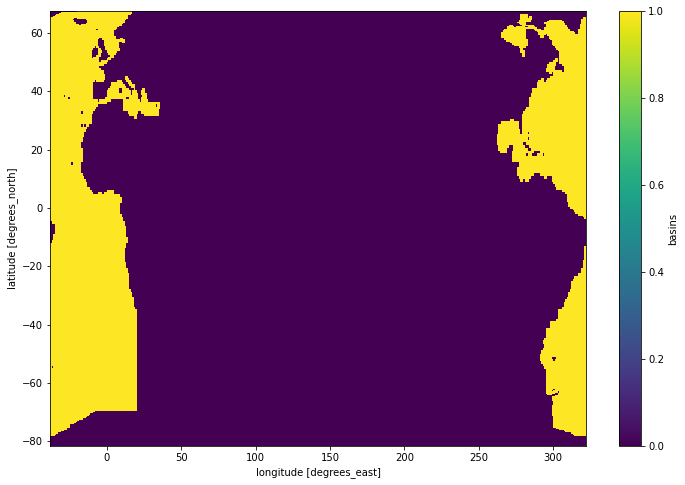

In [10]:
atl_basins = [2, 7, 9, 10, 12, 19]
atl_mask = sum([ds.basins == basin_num for basin_num in atl_basins])
atl_mask.plot()

In [11]:
grid = xgcm.Grid(ds, periodic=['X'])
grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center
X Axis (periodic, boundary=None):
  * center   lon_c --> left
  * left     lon_g --> center
Y Axis (not periodic, boundary=None):
  * center   lat_c --> left
  * left     lat_g --> center
T Axis (not periodic, boundary=None):
  * center   time --> inner
  * inner    time_snp --> center

In [20]:
mask_v = (grid.interp(atl_mask, 'Y', boundary='fill') > 0).compute()
volume_transport = (ds.VVELMASS * ds.drF * ds.dxG)
V_atl = volume_transport.where(mask_v).sum('lon_c')
V_rest = volume_transport.where(~mask_v).sum('lon_c')
V_atl

<xarray.DataArray (time: 288, Z: 50, lat_g: 240)>
dask.array<sum-aggregate, shape=(288, 50, 240), dtype=float32, chunksize=(1, 50, 89), chunktype=numpy.ndarray>
Coordinates:
    j_g      (lat_g) int64 30 31 32 33 34 35 36 ... 263 264 265 266 267 268 269
    k        (Z) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    PHrefC   (Z) float32 dask.array<chunksize=(50,), meta=np.ndarray>
  * Z        (Z) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
    drF      (Z) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * lat_g    (lat_g) float32 -81.61 -81.28 -80.95 -80.61 ... 67.06 67.25 67.4

In [21]:
import dask
with cluster.get_client():
    V_atl, V_rest = dask.compute(V_atl, V_rest)

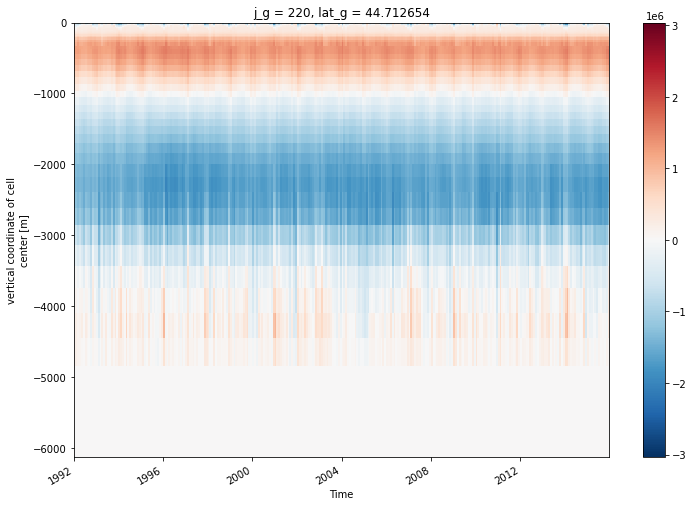

In [24]:
V_atl.sel(lat_g=45, method='nearest').plot(x='time')

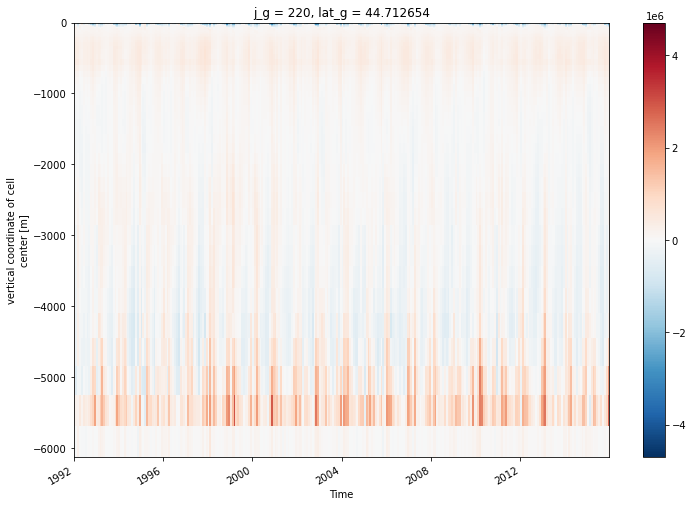

In [25]:
V_rest.sel(lat_g=45, method='nearest').plot(x='time')

In [44]:
Psi_atl = grid.cumsum(V_atl, 'Z', boundary='fill').sel(lat_g=slice(-30, None)) / 1e6
Psi_rest = grid.cumsum(V_rest, 'Z', boundary='fill').sel(lat_g=slice(-30, None)) / 1e6
Psi_SO = grid.cumsum(V_atl + V_rest, 'Z', boundary='fill').sel(lat_g=slice(None, -30)) / 1e6
Psi_tot = grid.cumsum(V_atl + V_rest, 'Z', boundary='fill') / 1e6

Text(0.5, 1.0, 'Global Overturning Streamfunction')

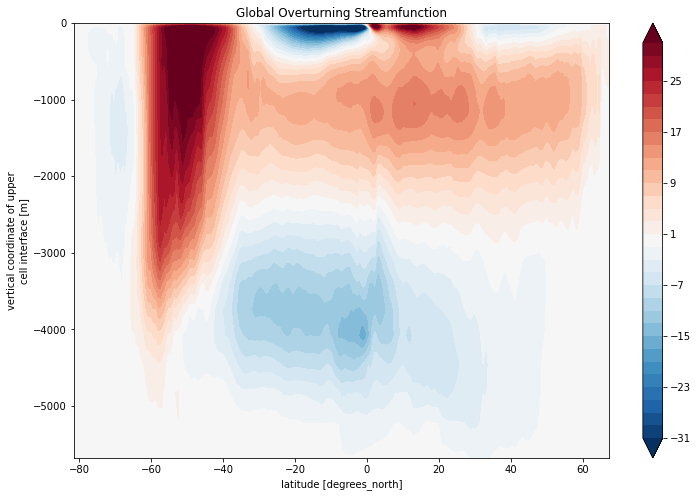

In [47]:
clevels = np.arange(-32, 32, 2) + 1
Psi_tot.mean('time').plot.contourf(levels=clevels, yincrease=True)
plt.title('Global Overturning Streamfunction')

Text(0.5, 1.0, 'North Atlantic Overturning Streamfunction')

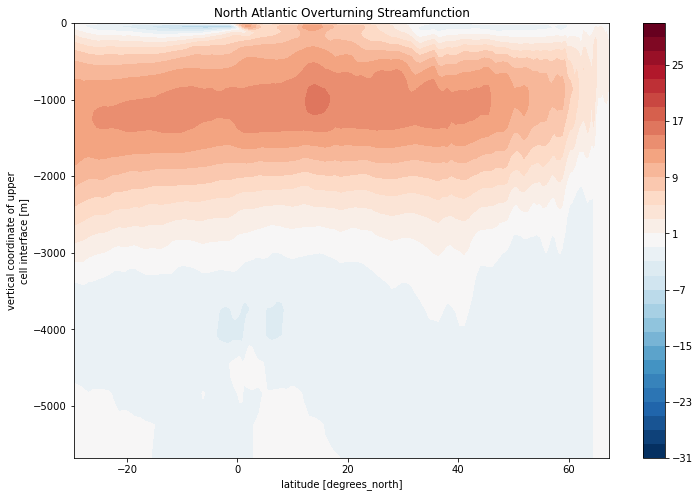

In [48]:
Psi_atl.mean('time').plot.contourf(levels=clevels, yincrease=True)
plt.title('North Atlantic Overturning Streamfunction')

Text(0.5, 1.0, 'North Pacific Overturning Streamfunction')

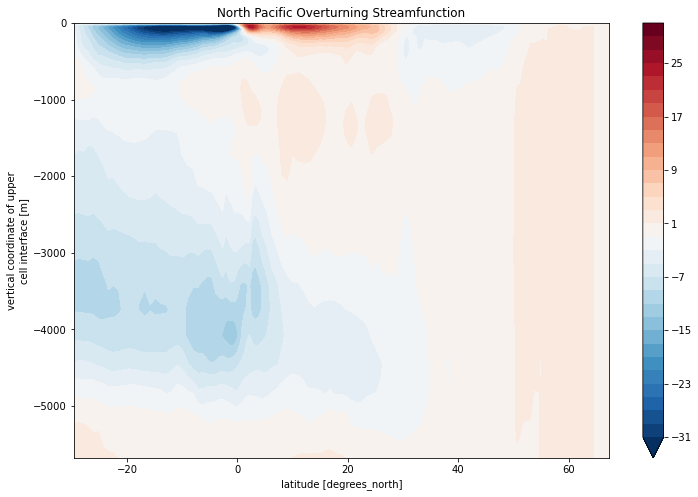

In [49]:
Psi_rest.mean('time').plot.contourf(levels=clevels, yincrease=True)
plt.title('North Pacific Overturning Streamfunction')

Text(0.5, 1.0, 'Southern Ocean Overturning Streamfunction')

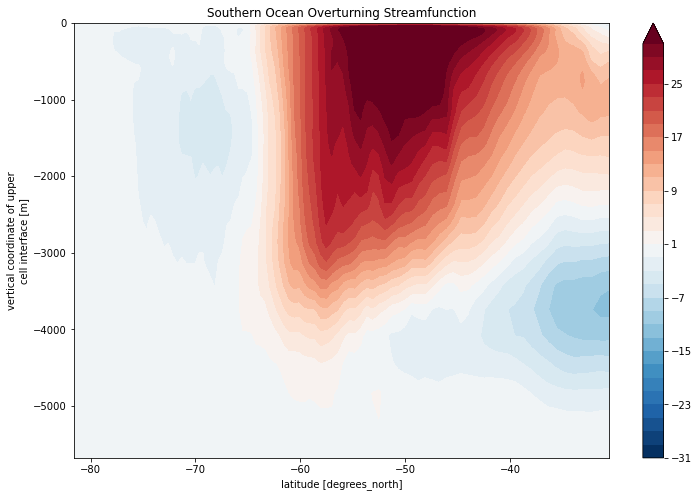

In [50]:
Psi_SO.mean('time').plot.contourf(levels=clevels, yincrease=True)
plt.title('Southern Ocean Overturning Streamfunction')